<p style="align: center;"><img align=center src="https://mailfit.com/wp-content/uploads/2019/11/lego-5.png"  width=900></p>
<h1 style="text-align: center;"><b>«Домашняя работа» - Множественное тестирование</b></h3>


## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Импорт данных

In [2]:
data_path = "https://raw.githubusercontent.com/a-milenkin/mipt_data_science_2021/main/data/people_data_clustering.csv"
data = pd.read_csv(data_path, index_col=0)
print("Размеры датасета", data.shape)
data.head(6)

Размеры датасета (6000, 9)


,was_married,children,salary,sex,age,profession,home_cost,drive_info,happyness
id,,,,,,,,,
0,1,4.0,4.420530e+07,1,82.0,Engineer,1.003674e+07,NaN,0.727499
1,1,2.0,1.737490e+08,1,32.0,Doctor,1.014051e+07,0.0,0.383234
2,1,6.0,2.489055e+08,1,14.0,Entertainment,1.043318e+07,NaN,0.432142
3,0,1.0,1.268718e+08,0,10.0,Lawyer,1.004299e+07,NaN,0.377987
4,1,9.0,8.596042e+07,1,99.0,Artist,1.021908e+07,NaN,0.657579
5,1,3.0,2.474979e+06,0,21.0,Homemaker,1.001654e+07,1.0,0.326801


<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой информацию по жителям некоторого города.

* `was_married` - Был ли когда-либо женат/замужем
* `children` - Количество детей
* `salary` - Уровень зарплаты
* `sex` - Пол (0 - женщина, 1 - мужчина)
* `age` - Возраст
* `home_cost` - Сумарная стоимость жилья/недвижимости
* `Professon` - Профессия
* `drive_info` - Есть ли водительские права
* `happyness` - уровень счастья по результатам опроса
    
</div>

<div class="alert alert-info">
<b>Задание</b>

Изучить датасет, выполнить задания и проверить некоторые гипотезы, предложенные ниже, опираясь уже **НЕ** только на визуализацию. Само задание выполнить на языке **Python**.
   

# Чистка датасета
* Есть ли дубли в данных? Если есть - удалить (drop_duplicates). 
* Есть ли пропуски в данных? Если есть - удалить столбцы, в которых они есть. (dropna())
* Найти и удалить/отфильтровать выбросы по признаку `home_cost`. Сколько их?

### задание 1

In [3]:
# Проверка на дубликаты в данных
duplicates = data.duplicated().sum()

# Удаление дубликатов, если они есть
if duplicates > 0:
    data = data.drop_duplicates()

duplicates

0

### задание 2

In [7]:
def missing_values(df):
    """
    Функция для вычисления процентного соотношения пропусков в каждом столбце датафрейма.

    :param df: исходный датафрейм pandas
    :return: новый датафрейм с двумя столбцами: 'Column' и 'Missing Percentage'
    """
    # Вычисление процента пропусков для каждого столбца
    missing_percentage = df.isnull().mean() * 100
    
    # Округление до двух знаков после запятой
    missing_percentage = missing_percentage.round(2)
    
    # Создание нового датафрейма с результатами
    missing_df = pd.DataFrame({
        'Столбцы': missing_percentage.index,
        'Пропущено в %': missing_percentage.values
    })
    
    # Сортировка по проценту пропусков от большего к меньшему
    missing_df = missing_df.sort_values(by='Пропущено в %', ascending=False).reset_index(drop=True)
    
    return missing_df

# Применение функции к датафрейму
missing_values_df = missing_values(data)
missing_values_df

,Столбцы,Пропущено в %
0,drive_info,46.17
1,was_married,0.00
2,children,0.00
3,salary,0.00
4,sex,0.00
5,age,0.00
6,profession,0.00
7,home_cost,0.00
8,happyness,0.00


In [8]:
# Удаление строк с пропущенными значениями в 'drive_info'
data = data.dropna(subset=['drive_info'])

# делаем итоговую проверку, после очистки
missing_values_df = missing_values(data)
missing_values_df

,Столбцы,Пропущено в %
0,was_married,0.0
1,children,0.0
2,salary,0.0
3,sex,0.0
4,age,0.0
5,profession,0.0
6,home_cost,0.0
7,drive_info,0.0
8,happyness,0.0


### задание 3

Для определения выбросов по признаку home_cost мы можем использовать метод IQR (межквартильный размах).

- Сначала мы найдем первый (Q1) и третий квартили (Q3) для home_cost. 
- Затем мы вычислим IQR как разность между Q3 и Q1. 
- Наконец, любые значения home_cost, которые находятся за пределами $[Q1−1.5×IQR,Q3+1.5×IQR]$, будут считаться выбросами.

In [9]:
# Вычисление Q1 и Q3 для 'home_cost'
Q1 = data['home_cost'].quantile(0.25)
Q3 = data['home_cost'].quantile(0.75)

# Вычисление IQR
IQR = Q3 - Q1

# Определение границ для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Нахождение выбросов
outliers = data[(data['home_cost'] < lower_bound) | (data['home_cost'] > upper_bound)]

# Количество выбросов
num_outliers = outliers.shape[0]

# Удаление выбросов
data_no_outliers = data[~data.index.isin(outliers.index)]


print("Количество выбросов:", num_outliers)
print("Размерность после очистки:", data_no_outliers.shape)

Количество выбросов: 8
Размерность после очистки: (3222, 9)


# Проверка гипотез

# Изучение датасета 
* Какие признаки численные?
* Какие признаки категориальные?
* Какие признаки имеют нормальное распределение?
* Какие признаки бессмысленные?

### здание 1 и 2

In [10]:
# Для этого напишем функцию
def advanced_categorize_columns(df):
    """
    Функция классифицирует столбцы датафрейма как числовые или категориальные.
    Столбцы, которые состоят только из 1, 0 (или 1.0, 0.0).

    :param df: датафрейм pandas
    :return: (numeric_columns, categorical_columns) - кортеж из двух списков
    """
    numeric_columns = []
    categorical_columns = []

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            # Если столбец состоит только из 1, 0 (или 1.0, 0.0) и NaN, считаем его категориальным
            unique_values = df[col].dropna().unique()
            if set(unique_values) <= {0, 1}:
                categorical_columns.append(col)
            else:
                numeric_columns.append(col)
        else:
            categorical_columns.append(col)
    
    return numeric_columns, categorical_columns

# Применение функции к датафрейму
numeric_columns, categorical_columns = advanced_categorize_columns(data)

print("Числовые столбцы:", numeric_columns)
print("Категориальные столбцы:", categorical_columns)

Числовые столбцы: ['children', 'salary', 'age', 'home_cost', 'happyness']
Категориальные столбцы: ['was_married', 'sex', 'profession', 'drive_info']


### здание 3

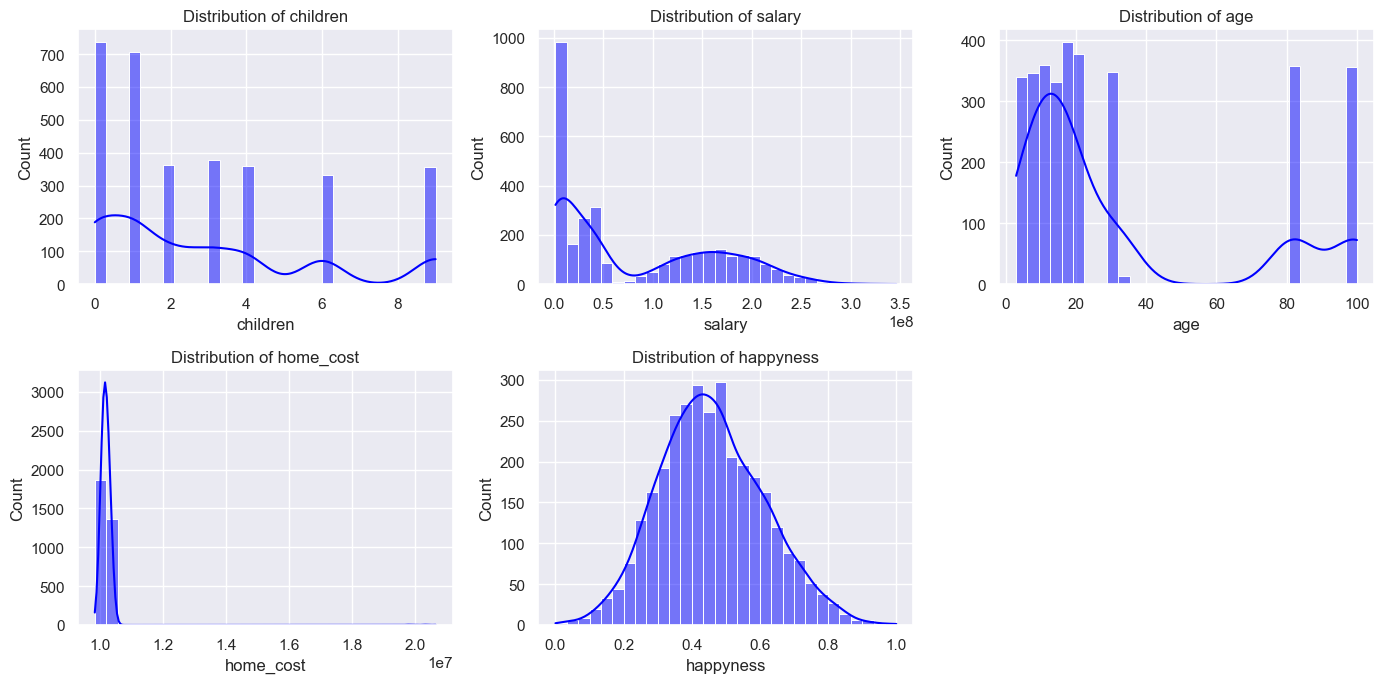

In [11]:
import seaborn as sns

# Функция для построения гистограмм и графиков плотности распределения
def distribution_plots(df, columns):
    plt.figure(figsize=(14, 7))
    for i, col in enumerate(columns, 1):
        plt.subplot(2, 3, i)
        sns.histplot(df[col], kde=True, bins=30, color='blue')  # Построение гистограммы и графика плотности
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

# Построение графиков распределения для числовых признаков
distribution_plots(data, numeric_columns)

На графиках выше представлены гистограммы и графики плотности распределения для каждого числового признака. Из графиков видно, что:

- `children` имеет положительную асимметрию и не следует нормальному распределению.
- `salary` также имеет положительную асимметрию и не следует нормальному распределению.
- `age` имеет распределение, близкое к нормальному, но с некоторой положительной асимметрией.
- `home_cost` показывает небольшую положительную асимметрию.
- `happyness` имеет близкое к нормальному распределение.

Исходя из этих визуализаций, можно сказать, что признак happyness имеет распределение, наиболее близкое к нормальному.

Также, чтобы полностью убедиться в нашей право проведем еще тест на нормальное распределение при помощи p-value

### здание 4

C:\Users\Nekon\AppData\Local\Temp\ipykernel_13040\3821846555.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  new_correlation_matrix = data.corr()


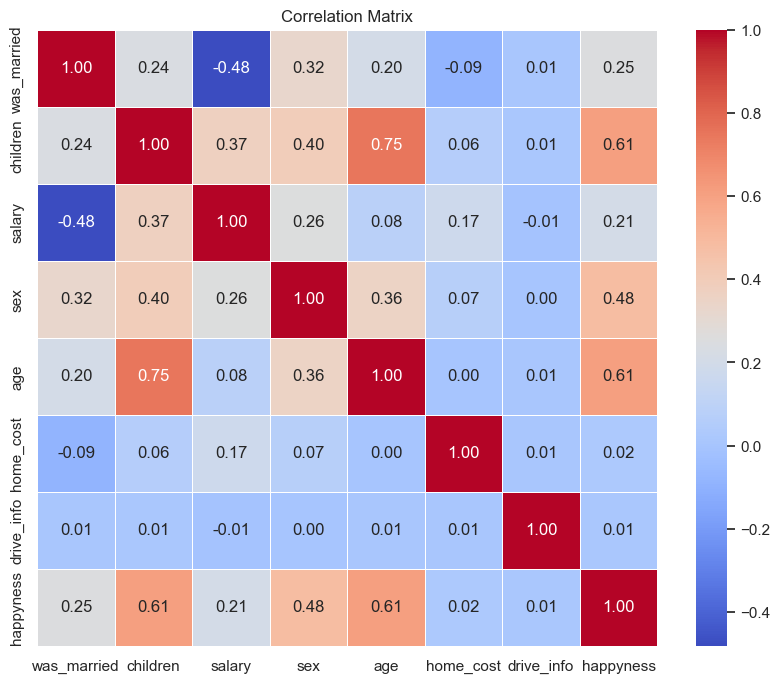

In [12]:
# Импорт библиотеки для визуализации
import seaborn as sns
import matplotlib.pyplot as plt

# Построение новой матрицы корреляции
new_correlation_matrix = data.corr()

# Визуализация матрицы корреляции с использованием heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(new_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Итоги.

На наш взгляд, неинформативными являются признаки:

- `drive_info`
- `home_cost`

<div class="alert alert-info">

<b>Задание:</b>    
    
Перед вами уже знакомый датасет, который был дан в прошлых домашних заданиях. Вы уже научились применить подходящий статистический критерий для двух групп, теперь вам предстоит научиться верно применять критерии для нескольких групп одновременно. 
    

<div class="alert alert-warning">
    
* Правда ли между представителями таких профессий как, **Homemaker**, **Marketing**, **Healthcare** и **Executive** в среднем  зарплаты не отличаются между собой? Ответ подкрепите визуализацией и подходящим статистическим критерием. 

Гипотезы:
- $H_0$: Средние зарплаты между представителями профессий Homemaker, Marketing, Healthcare и Executive не отличаются.
- $H_1$: По крайней мере две профессии имеют различные средние зарплаты.

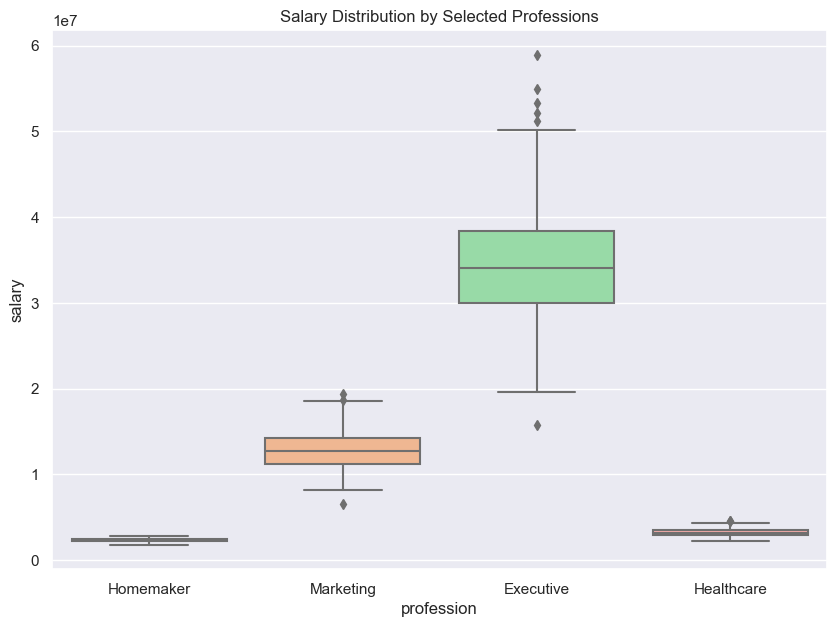

F-stat: 7081.112135812555
p-value: 0.0


In [13]:
from scipy.stats import f_oneway

# Визуализация распределения зарплат для выбранных профессий с использованием boxplot
selected_professions_data = data[data['profession'].isin(['Homemaker', 'Marketing', 'Healthcare', 'Executive'])]
plt.figure(figsize=(10, 7))
sns.boxplot(data=selected_professions_data, x='profession', y='salary', palette="pastel")
plt.title('Salary Distribution by Selected Professions')
plt.show()

# Фильтрация данных по профессиям
homemaker_salaries = data[data['profession'] == 'Homemaker']['salary']
marketing_salaries = data[data['profession'] == 'Marketing']['salary']
healthcare_salaries = data[data['profession'] == 'Healthcare']['salary']
executive_salaries = data[data['profession'] == 'Executive']['salary']

# Применение однофакторного дисперсионного анализа
f_stat, p_value_anova = f_oneway(homemaker_salaries, marketing_salaries, healthcare_salaries, executive_salaries)

print("F-stat:", f_stat)
print("p-value:", p_value_anova)

- `F-статистика`: $7081.112135812555$
- `p-значение`: $0.0$

Эти результаты указывают на то, что существуют значимые различия в средних зарплатах между представителями профессий Homemaker, Marketing, Healthcare и Executive. 

p-значение равно 0, что гораздо меньше порога значимости $α=0.05$, поэтому мы отвергаем нулевую гипотезу $H_0$ и принимаем альтернативную гипотезу $H_1$.

Это означает, что по крайней мере две из этих профессий имеют различные средние зарплаты. Для выяснения, какие именно группы отличаются друг от друга, можно использовать методы пост-анализа (например, тест Тьюки).

In [14]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Фильтрация данных для выбранных профессий
selected_professions_data = data[data['profession'].isin(['Homemaker', 'Marketing', 'Healthcare', 'Executive'])]

# Проведение теста Тьюки
tukey_result = pairwise_tukeyhsd(endog=selected_professions_data['salary'], 
                                 groups=selected_professions_data['profession'], 
                                 alpha=0.05)

# Вывод результатов
print(tukey_result)

              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
  group1     group2      meandiff    p-adj      lower          upper      reject
--------------------------------------------------------------------------------
 Executive Healthcare -31058054.1754    0.0 -31689373.6099  -30426734.741   True
 Executive  Homemaker -31951386.6488    0.0 -32590354.2474 -31312419.0502   True
 Executive  Marketing -21470237.8052    0.0 -22122581.0132 -20817894.5971   True
Healthcare  Homemaker   -893332.4733 0.0011  -1507299.9938   -279364.9529   True
Healthcare  Marketing   9587816.3703    0.0   8959940.4389  10215692.3016   True
 Homemaker  Marketing  10481148.8436    0.0   9845583.3088  11116714.3784   True
--------------------------------------------------------------------------------


Между всеми парами профессий (Executive и Healthcare, Executive и Homemaker, Executive и Marketing, Healthcare и Homemaker, Healthcare и Marketing, Homemaker и Marketing) есть статистически значимые различия в средних зарплатах, так как 
p-значение равно 0 для всех сравнений, и все значения reject равны True.
meandiff показывает разницу в средних между группами. Отрицательные значения указывают на то, что средняя зарплата в первой группе выше, чем во второй.

Например, средняя зарплата в группе Executive на 31,058,054 выше, чем в группе Healthcare.

Таким образом, мы видим, что средние зарплаты между этими профессиями действительно отличаются, и наше исследование подтверждает это статистически.

<div class="alert alert-warning">
    
* Правда ли между представителями таких профессий как, **Doctor**, **Entertainment** и **Lawyer** в среднем  зарплаты не отличаются между собой? Ответ подкрепите визуализацией и подходящим статистическим критерием. 

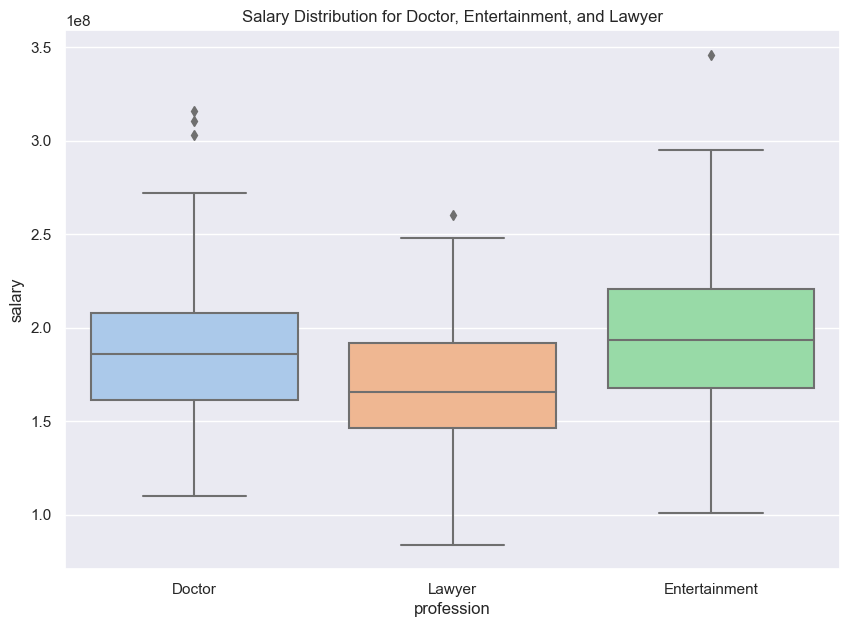

F-stat: 52.044633655562954
p-value: 2.8160272565678785e-22


In [16]:
# Фильтрация данных для выбранных профессий
selected_professions_data_2 = data[data['profession'].isin(['Doctor', 'Entertainment', 'Lawyer'])]

# Визуализация распределения зарплат с использованием boxplot
plt.figure(figsize=(10, 7))
sns.boxplot(data=selected_professions_data_2, x='profession', y='salary', palette="pastel")
plt.title('Salary Distribution for Doctor, Entertainment, and Lawyer')
plt.show()

# Фильтрация данных по профессиям
doctor_salaries = data[data['profession'] == 'Doctor']['salary']
entertainment_salaries = data[data['profession'] == 'Entertainment']['salary']
lawyer_salaries = data[data['profession'] == 'Lawyer']['salary']

# Применение однофакторного дисперсионного анализа
f_stat_2, p_value_anova_2 = f_oneway(doctor_salaries, entertainment_salaries, lawyer_salaries)

print("F-stat:", f_stat_2)
print("p-value:", p_value_anova_2)

- `F-статистика`: $52.044633655562954$
- `p-значение`: $2.8160272565678785e-22$

Эти результаты указывают на то, что существуют значимые различия в средних зарплатах между представителями профессий Doctor, Entertainment и Lawyer p-значение гораздо меньше порога значимости $α=0.05$, поэтому мы отвергаем нулевую гипотезу $H_0$ и принимаем альтернативную гипотезу $H_1$, что средние зарплаты отличаются между этими профессиями.

In [17]:
# Фильтрация данных для выбранных профессий
selected_professions_data_2 = data[data['profession'].isin(['Doctor', 'Entertainment', 'Lawyer'])]

# Проведение теста Тьюки
tukey_result_2 = pairwise_tukeyhsd(endog=selected_professions_data_2['salary'], 
                                   groups=selected_professions_data_2['profession'], 
                                   alpha=0.05)

# Вывод результатов
print(tukey_result_2)

                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
    group1        group2       meandiff    p-adj      lower          upper      reject
--------------------------------------------------------------------------------------
       Doctor Entertainment   8573777.8219 0.0047   2201117.2831  14946438.3607   True
       Doctor        Lawyer -18392377.4189    0.0  -24629698.724 -12155056.1138   True
Entertainment        Lawyer -26966155.2408    0.0 -33343047.9778 -20589262.5038   True
--------------------------------------------------------------------------------------


- Doctor и Entertainment: средняя зарплата у представителей Entertainment выше на 8,573,777.8219 по сравнению с Doctor. 
p-значение 0.0047подтверждает, что различие статистически значимо.
- Doctor и Lawyer: средняя зарплата у представителей Lawyer ниже на 18,392,377.4189 по сравнению с Doctor. 
p-значение 0.0 подтверждает, что различие статистически значимо.
- Entertainment и Lawyer: средняя зарплата у представителей Lawyer ниже на 26,966,155.2408 по сравнению с Entertainment. 
p-значение 0.0 подтверждает, что различие статистически значимо.

<div class="alert alert-warning">
    
Допустим вы рассматриваете 4 группы населения, отличающихся количеством  детей. Группы следующие.
* **A** - нет детей
* **B** - 1 ребенок
* **C** - от 2 до 4 детей
* **D** - от 5 детей    
    
    
* Правда ли, что эти группы отличаются статистически значимо по уровню дохода и уровню счастья? Ответ поддержите статистическими критериями и визуализацией

Для анализа различий в уровне дохода и уровне счастья между группами населения, отличающихся количеством детей, можно использовать ANOVA (для сравнения средних в нескольких группах) и визуализировать данные с помощью boxplot.

Сначала создадим новую переменную для группировки данных по количеству детей:

In [18]:
# Категоризация по количеству детей
def categorize_children(number_of_children):
    if number_of_children == 0:
        return 'A'
    elif number_of_children == 1:
        return 'B'
    elif 2 <= number_of_children <= 4:
        return 'C'
    else:
        return 'D'

data['children_category'] = data['children'].apply(categorize_children)

### Анализ уровня дохода

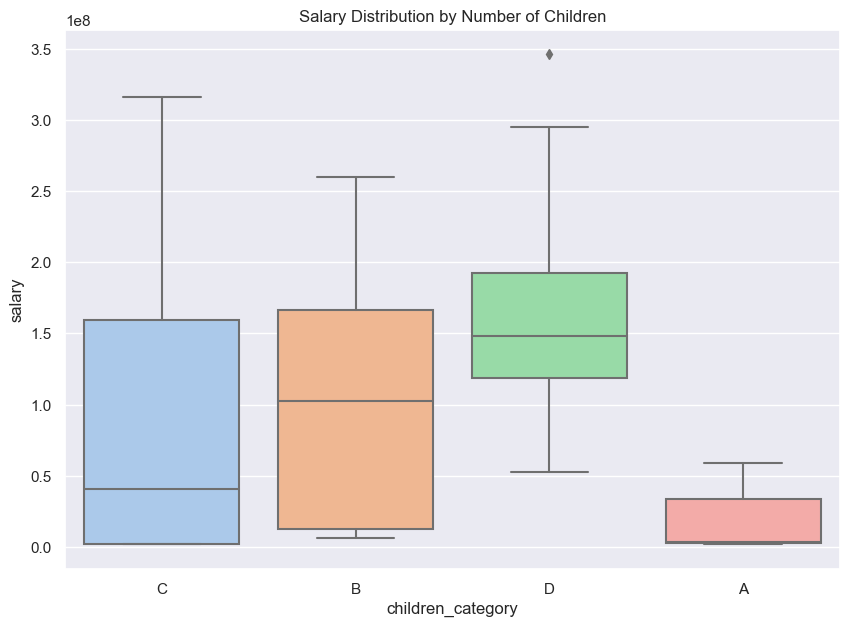

F-stat (Salary): 543.5575886257436
p-value (Salary): 6.772013575390892e-286


In [19]:
# Визуализация распределения дохода для разных групп населения
plt.figure(figsize=(10, 7))
sns.boxplot(data=data, x='children_category', y='salary', palette="pastel")
plt.title('Salary Distribution by Number of Children')
plt.show()

# Применение однофакторного дисперсионного анализа для дохода
f_stat_salary, p_value_anova_salary = f_oneway(
    data[data['children_category'] == 'A']['salary'],
    data[data['children_category'] == 'B']['salary'],
    data[data['children_category'] == 'C']['salary'],
    data[data['children_category'] == 'D']['salary']
)

print("F-stat (Salary):", f_stat_salary)
print("p-value (Salary):", p_value_anova_salary)

Существуют статистически значимые различия в доходе между группами с разным количеством детей. 
p-значение крайне мало, что подтверждает статистическую значимость результатов.

### Анализ уровня счастья

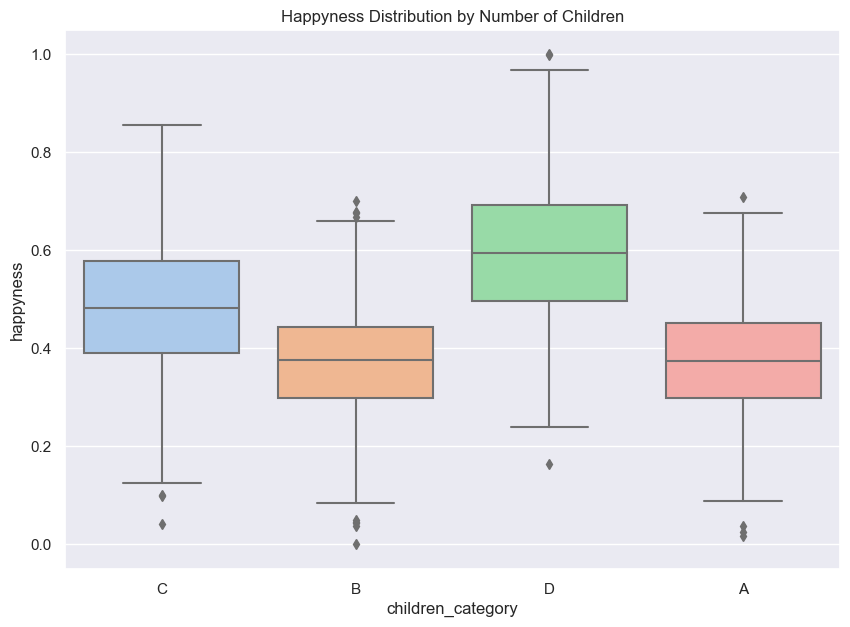

F-stat (Happyness): 500.5626779468605
p-value (Happyness): 4.728384961076856e-267


In [22]:
# Визуализация распределения уровня счастья для разных групп населения
plt.figure(figsize=(10, 7))
sns.boxplot(data=data, x='children_category', y='happyness', palette="pastel")
plt.title('Happyness Distribution by Number of Children')
plt.show()

# Применение однофакторного дисперсионного анализа для уровня счастья
f_stat_happyness, p_value_anova_happyness = f_oneway(
    data[data['children_category'] == 'A']['happyness'],
    data[data['children_category'] == 'B']['happyness'],
    data[data['children_category'] == 'C']['happyness'],
    data[data['children_category'] == 'D']['happyness']
)

print("F-stat (Happyness):", f_stat_happyness)
print("p-value (Happyness):", p_value_anova_happyness)

Аналогично доходу, существуют статистически значимые различия в уровне счастья между группами с разным количеством детей.

Таким образом, можно с уверенностью сказать, что количество детей в семье влияет как на уровень дохода, так и на уровень счастья.